In [3]:
using Distributions, ForwardDiff, LinearAlgebra, Gadfly, Cairo, Fontconfig

include("../precipModel/iGMRF.jl");
include("../precipModel/dataGen.jl");
include("../precipModel/framework.jl");
include("../precipModel/plotting.jl");
include("CAVI.jl");

In [147]:
# Seed
Random.seed!(400);
# Dimensions de la grille
m₁ = 3;
m₂ = 3;
# Nb total de cellules
m = m₁ * m₂;
# Matrice de structure
κᵤ = 10.0;
F = iGMRF(m₁, m₂, κᵤ);
# Grille cible
grid_target = generateTargetGrid(F);
grid_target[:, :, 1] = grid_target[:, :, 1] .+ 10;
# Génération de données
nobs = 100;
Y = generateData(grid_target, nobs);

# Itérations

In [148]:
n_epoch = 100;

MCKL, Hθ = runCAVI(n_epoch, 1000, F=F, Y=Y);

Initialization made in 0.003159333 s
Minimization made in 1.157500042 s


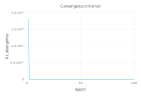

In [ ]:
plotConvergenceCriterion(
    MCKL,
    # "../plots/mean_field/$(m₁)x$(m₂)/convergence_criterion.png",
)

In [150]:
η = Hθ[1:m];
bᵤ = Hθ[m + 1];
aᵤ = compute_aᵤ(m);
s² = compute_s²(aᵤ, bᵤ, length(Y[1]), [diag(F.G.W)...]);

In [151]:
include("mcmc.jl");

niter = 100000
δ² = 0.2
κᵤ₀ = 10
μ₀ = zeros(m)

θ = gibbs(niter, Y, m₁=m₁, m₂=m₂, δ²=δ², κᵤ₀=κᵤ₀, μ₀=μ₀);

warming_size = Int(0.2 * niter);
θsampling = θ[warming_size:end, :, :];

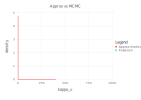

In [ ]:
# Pour κᵤ

approxDensity(x::Real) = pdf(Gamma(aᵤ, bᵤ), x)
a = 0;
step = 0.1;
b = 400;

plotApproxVSMCMC(
    approxDensity,
    θsampling.value[:, 1, 1],
    # "../plots/mean_field/$(m₁)x$(m₂)/approxvsmcmc_kappa.png",
    a=a,
    b=b,
    step=step;
    xLabel="kappa_u",
    yLabel="density",
)

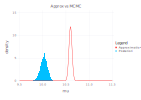

In [ ]:
# Pour μ

approxDensity(x::Real) = pdf(Normal(η[1], sqrt(s²[1])), x);
a = 9.5;
b = 11.5;
step = .001;

plotApproxVSMCMC(
    approxDensity,
    θsampling.value[:, 2, 1],
    # "../plots/mean_field/$(m₁)x$(m₂)/approxvsmcmc_mu.png",
    a=a,
    b=b,
    step=step,
    xLabel="mu",
    yLabel="density",
)